In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")

import sheet_unfolding.sim as sim
from matplotlib.colors import LogNorm

# git clone https://github.com/simongibbons/pyfof
import pyfof 
# pyfof needs boost to be installed.
'''
add the boost location via
export CPLUS_INCLUDE_PATH=$(brew --prefix boost)/include
export LIBRARY_PATH=$(brew --prefix boost)/lib
'''

# import pyFoF as pyfof 
# need the following command to avoid dependency conflicts "pip install --upgrade --no-deps fofpy"

'\nadd the boost location via\nexport CPLUS_INCLUDE_PATH=$(brew --prefix boost)/include\nexport LIBRARY_PATH=$(brew --prefix boost)/lib\n'

# Goals:
* Run a friends of friends algorithm on a simulation
* Plot particles that are in haloes
* Plot a halo mass function
* Plot displacement fields in Lagrangian space
* Plot halo particles in Lagrangian space


# Run a simulation
this code you don't need to write here

In [2]:
myic = sim.ic.IC2DCosmo(512, L=100., rs=1.5, sigma8=2.)

mysim = sim.CosmologicalSimulation2d(myic, aic=0.02, dafac_max=0.05, da_max=0.02, ngrid_pm=128)

mysim.integrate_till(1.)

integrate time 2.0000e-02 -> 1.0000e+00  with da=0.001  (980 steps)


Text(0, 0.5, '$y$ [Mpc/$h$]')

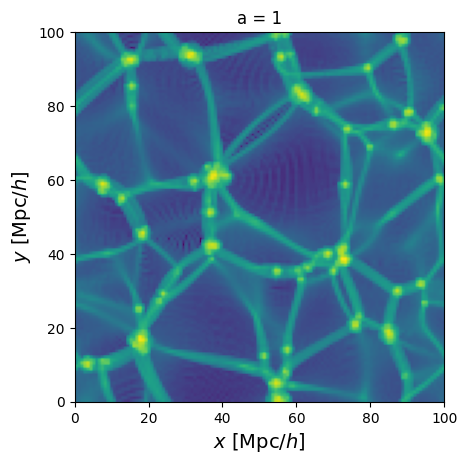

In [3]:
rho = sim.sim.deposit2d(mysim.pos, 128, myic.L, mode="cic")
plt.imshow(np.clip(rho / np.mean(rho), 1e-2, None).T, origin="lower", norm = LogNorm(vmin=1e-2, vmax=1e2), extent=[0,100.,0.,100.])
plt.title("a = %g" % mysim.a)
plt.xlabel(r"$x$ [Mpc/$h$]", fontsize=14)
plt.ylabel(r"$y$ [Mpc/$h$]", fontsize=14)

# Use a Friends of Friends algorithm to detect haloes
install the module "pyfof". In linux you could do it e.g. with

```pip install pyfof```

Make sure to learn how to install python modules with a single command, because you will need it often.

Read a bit about the friends of friends algorithm. E.g. here: https://swift.dur.ac.uk/docs/FriendsOfFriends/algorithm_description.html

Then find friends of friends groups with a linking length of 0.2 mean particle separations. Discard all groups which have less than 20 members. Then make a density plot of all particles that are in a group with N>=20 members

Note: What we are doing here is not exactly correct, because we are neglecting the periodic boundary conditions. However, let's keep it simple for now ;)

In [4]:
linking_length = 0.2*np.sqrt(np.mean(100.**2/512.**2))
print(linking_length)

0.0390625


In [5]:
import importlib.util

spec = importlib.util.find_spec("pyfof")
print(spec.origin)

/Users/hong-gangyang/anaconda3/envs/marcos_test/lib/python3.11/site-packages/pyfof.cpython-311-darwin.so


In [6]:
res = pyfof.friends_of_friends(mysim.pos.reshape(-1,2), linking_length)

/var/folders/zw/60xz9kgx1pq6wsz9pv89s8cc0000gn/T/ipykernel_61545/3162636916.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  res = pyfof.friends_of_friends(mysim.pos.reshape(-1,2), linking_length)


In [11]:
allids = []
for igroup,inds_in_group in enumerate(res):
    if len(inds_in_group) >= 20:
        allids += inds_in_group
allids = np.array(allids)

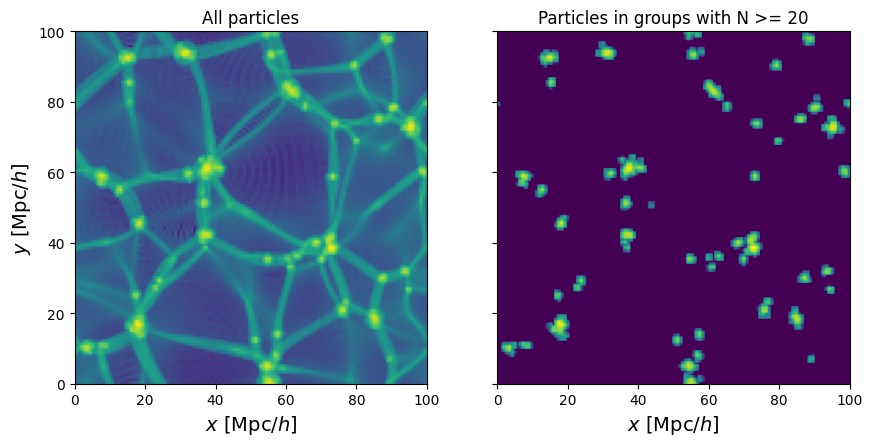

In [18]:
rho1 = sim.sim.deposit2d(mysim.pos, 128, myic.L, mode="cic")
rho2 = sim.sim.deposit2d(mysim.pos.reshape(-1,2)[allids], 128, myic.L, mode="cic")

fig, axs = plt.subplots(1,2, figsize=(10,5),sharey=True)
axs[0].imshow(np.clip(rho1 / np.mean(rho1), 1e-2, None).T, origin="lower", norm = LogNorm(vmin=1e-2, vmax=1e2), extent=[0,100.,0.,100.])
axs[1].imshow(np.clip(rho2 / np.mean(rho1), 1e-2, None).T, origin="lower", norm = LogNorm(vmin=1e-2, vmax=1e2), extent=[0,100.,0.,100.])
axs[0].set_title("All particles")
axs[1].set_title("Particles in groups with N >= 20");
for ax in axs:
    ax.set_xlabel(r"$x$ [Mpc/$h$]", fontsize=14)
axs[0].set_ylabel(r"$y$ [Mpc/$h$]", fontsize=14)

plt.savefig("img/haloes_versus_particles.png", bbox_inches="tight")

# Plot a mass function
Plot the fof mass function. I.e. the number of objects with a given mass (through a histogram). The mass of a fof-group equals the sum of the masses of the particles in the group. Since all particles have equal mass, you can just multiply the length of the group by the particle mass $m_0$

In [19]:
m0 = mysim.mass[0,0]
print(m0)

10587690962.236044


In [20]:
lens = []
ifof = np.zeros(mysim.pos.shape[0:2], dtype=np.int64)
for igroup,inds_in_group in enumerate(res):
    if len(inds_in_group) > 20:
        lens.append(len(inds_in_group))

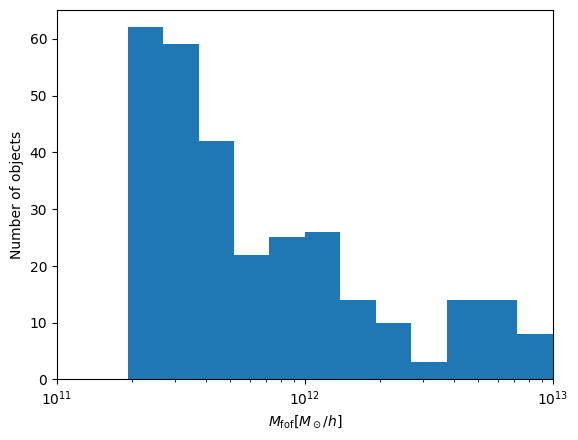

In [21]:
bins = np.logspace(11,13,15)
plt.hist(np.array(lens)*m0, bins=bins)
plt.xscale("log")
plt.xlabel(r"$M_{\rm{fof}} [M_\odot / h]$")
plt.ylabel("Number of objects")
plt.xlim(1e11, 1e13)
plt.savefig("img/haloes_massfunction.png")

# Lagrangian space

Let's plot the displacement field in Lagrangian space. (This first new exercise is independent of the previous ones).

Lagrangian space is the space of the initial locations of particles. We started with all particles on a grid (myic.qi[...,0:2]). Since we kept all particles in the same order, making a Lagrangian plot can be as simple as an plt.imshow(myparticleproperty, ...)

The displacement field  $\vec{s}$ describes how much a particle moved from its initial location and it is defined so that

\begin{align}
\vec{x}(\vec{q}) = \vec{q} + \vec{s}(\vec{q})
\end{align}

where $\vec{x}$ are the particle positions and $\vec{q}$ their Lagrangian (initial coordinates). Therefore in principle $\vec{s} = \vec{x} - \vec{q}$. However, since we always wrap particle positions periodically between [0,L], you have to undo the periodic wrapping. You can do this by subtracting/adding +-L so that $\vec{s}$ lies in [-L/2, L/2].

Make a plot of each, the x and y components, of $\vec{s}$ in Lag. space. Further, put a quiver plot on top to indicate the displacement by arrows.

In [12]:
L = 100.
disp = (((mysim.pos - myic.qi) + L/2.) % L) - L/2.

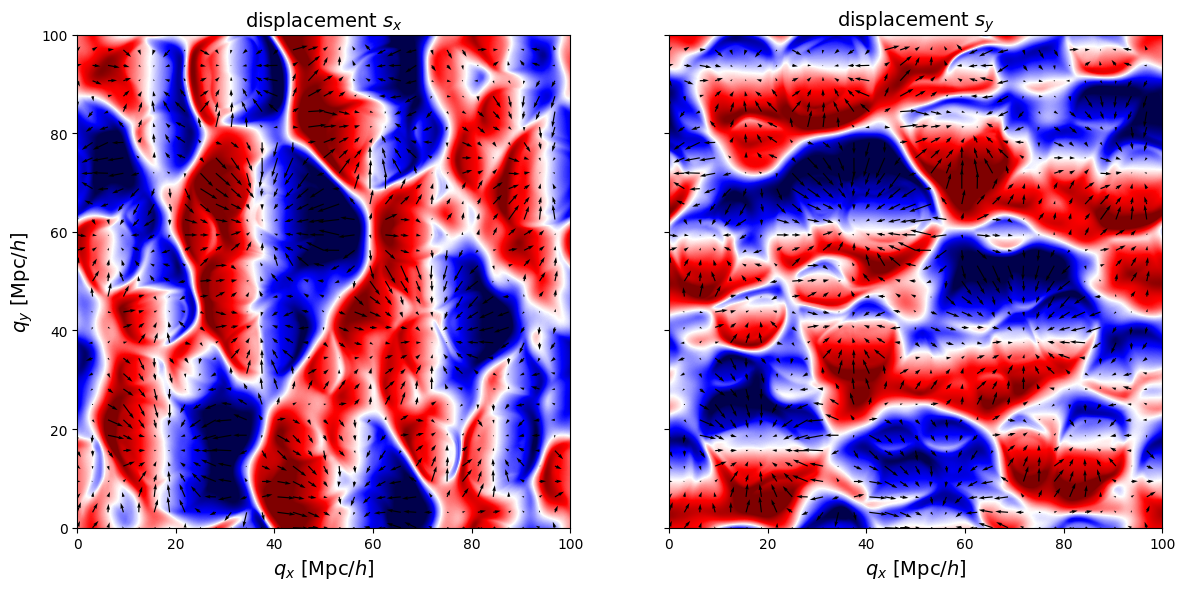

In [13]:
fig, axs = plt.subplots(1,2, figsize=(14,8), sharey=True)

axs[0].imshow(disp[...,0].T, origin="lower", extent=[0,100.,0.,100.],cmap="seismic",vmin=-10.,vmax=10.)
axs[1].imshow(disp[...,1].T, origin="lower", extent=[0,100.,0.,100.],cmap="seismic",vmin=-10.,vmax=10.)
for ax in axs:
    ax.quiver(myic.qi[::16,::16,0], myic.qi[::16,::16,1], disp[::16,::16,0], disp[::16,::16,1], color="black")
    ax.set_xlabel(r"$q_x$ [Mpc/$h$]", fontsize=14)
axs[0].set_ylabel(r"$q_y$ [Mpc/$h$]", fontsize=14)

axs[0].set_title(r"displacement $s_x$", fontsize=14)
axs[1].set_title(r"displacement $s_y$", fontsize=14)
plt.savefig("img/haloes_lagrangian_displacement.png")

# Lagrangian space haloes

Now let's get to the plot I actually want. Plot the halo index in Lagrangian space, so that different haloes will have different colors. Also plot the displacement field on top as a quiver plot.

To get the halo index in Lagrangian space, you will have to mark each particle by the halo index it is part of. For this you will have to rearange a bit the information that you got from the output of pyfof

In [14]:
ifof = np.zeros(mysim.pos.shape[0:2], dtype=np.int64)
for igroup,inds_in_group in enumerate(res):
    if len(inds_in_group) > 20:
        ifof.flat[inds_in_group] = igroup

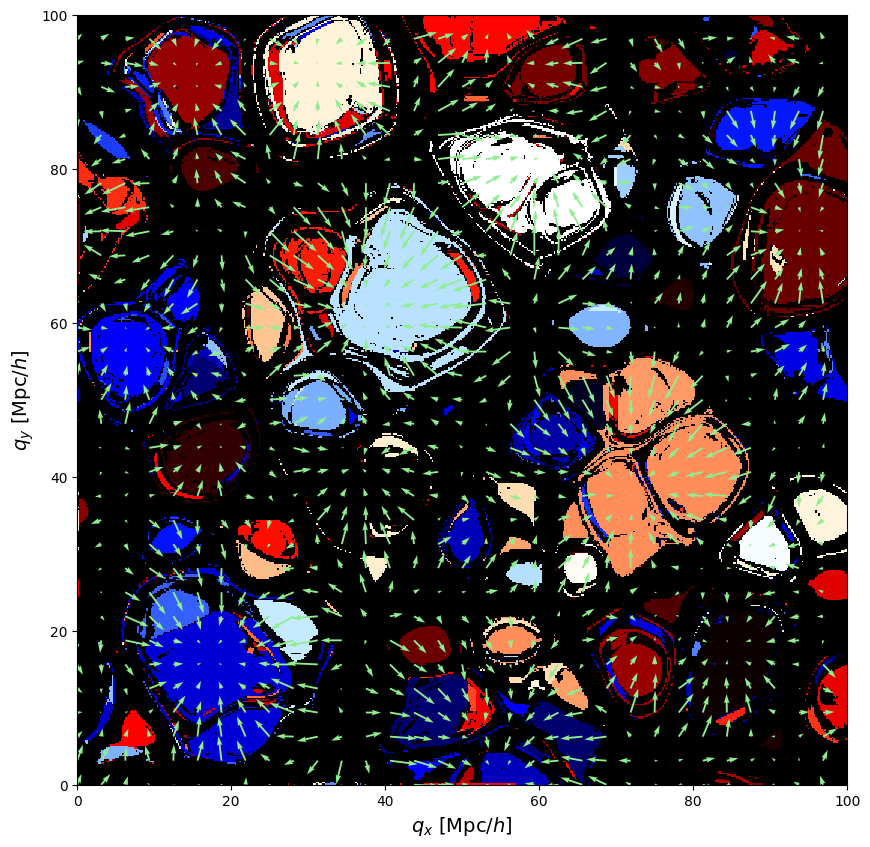

In [15]:
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.imshow(ifof.T, origin="lower", extent=[0,100.,0.,100.], cmap="flag_r", interpolation="none")
ax.quiver(myic.qi[::16,::16,0], myic.qi[::16,::16,1], disp[::16,::16,0], disp[::16,::16,1], color="lightgreen")

ax.set_xlabel(r"$q_x$ [Mpc/$h$]", fontsize=14)
ax.set_ylabel(r"$q_y$ [Mpc/$h$]", fontsize=14)
plt.savefig("img/haloes_lagrangian_protohaloes.png")